In [3]:
"""
compare footprints
"""

'\ncompare footprints\n'

In [4]:
from functools import partial
import glob
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pybedtools as pbt
import re
import subprocess
import sys

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import config_readwrite as crw
import chr_functions
import split_filename

In [37]:
name = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configfile_name = crw.read_config(name)

SHUF = config["SHUFFLES"]["shuf-all"]
REGIONS = config["CIS_TRANS"]["regions"]

ID_TAG = config["TF_FOOTPRINTING_JASPAR"]["ID_TAG"]

PATH = config["TF_FOOTPRINTING"]["PATH"]
RE = config["TF_FOOTPRINTING"]["results"]

RNA = config["RNASEQ"]["dif_exp"]
FPKM = config["RNASEQ"]["GM12878_FPKM"]

path, region_file, region = split_filename.split_filename(REGIONS)

0. string split to get TF name
1. intersect regions w footprint files
2. create matrix w/ region_id (should be 17605 regions x 693 archetypes) 

# functions

## load human footprint matrix and raw data

In [6]:
def load_data(cell_line, raw):
    
    MATRIX = config[f"TF_FOOTPRINTING_JASPAR_{cell_line}"]["matrix"]
    
    FP = config[f"TF_FOOTPRINTING_JASPAR_{cell_line}"]["FP"] # write
    
    if raw is True:
        
        cols= [
            "#chr",
            "start", "end", "region_id",
            "#chr_tf",
            "start_tf",
            "end_tf",
            "tfid",
            "score", 
            "strand",
            "overlap"
            ]
        FP = FP.strip('.bed') + "_clean.bed"
        print(FP)
        df = pd.read_csv(FP, sep='\t',
                        )
        df=df.drop_duplicates().reset_index()
        df["len"] = df["end_tf"] - df['start_tf']
        df = df.drop(columns=["level_0", "index"])
    else:
        df = pd.read_csv(MATRIX, sep='\t').fillna(0)
        
    return df

In [7]:
CL = "GM12878"
RAW = True
hu_raw = load_data(CL, RAW)
RAW = False
hu = load_data(CL, RAW)

/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/TF_footprint/GM12878_1.8-JASPAR_0.05-pval_morethan5bp_clean.bed


In [8]:
hu_raw.head()

,#chr,start,end,region_id,#chr_tf,start_tf,end_tf,tfid,score,strand,overlap,len,tfid2
0,chr1,10398650,10398760,chr1:10398650-10398760,chr1,10398748.0,10398754.0,AhrArnt_MA0006.1,7.23575,+,6.0,6.0,chr1:10398748.0:10398754.0_AhrArnt_MA0006.1
1,chr1,16366945,16367215,chr1:16366945-16367215,chr1,16367173.0,16367179.0,AhrArnt_MA0006.1,7.23575,+,6.0,6.0,chr1:16367173.0:16367179.0_AhrArnt_MA0006.1
2,chr1,18927637,18927877,chr1:18927637-18927877,chr1,18927818.0,18927824.0,AhrArnt_MA0006.1,7.23575,+,6.0,6.0,chr1:18927818.0:18927824.0_AhrArnt_MA0006.1
3,chr1,21294516,21294716,chr1:21294516-21294716,chr1,21294635.0,21294641.0,AhrArnt_MA0006.1,7.23575,-,6.0,6.0,chr1:21294635.0:21294641.0_AhrArnt_MA0006.1
4,chr1,23368748,23368928,chr1:23368748-23368928,chr1,23368877.0,23368883.0,AhrArnt_MA0006.1,7.23575,-,6.0,6.0,chr1:23368877.0:23368883.0_AhrArnt_MA0006.1


## describe the human footprints

In [9]:
n = hu[hu.columns[1:]].sum().reset_index()
n.describe()

,0
count,746.000000
mean,394.792225
std,338.923885
min,57.000000
25%,166.000000
50%,297.000000
75%,478.500000
max,2049.000000


## describe the rhesus footprints

In [10]:
def load_liftedover_fp(path):
    LIFTOVER = os.path.join(path, "LCL8664_1.liftOver.to.Hg38.bed")
    cols = ["#chr_tf_lifted", "start_tf_lifted", "end_tf_lifted", "tfid2", "region_id"]
    liftover = pd.read_csv(LIFTOVER, sep = '\t', header=None, names =cols)
    return liftover

In [11]:
CL, RAW = "LCL8664", True
rh_raw = load_data(CL, RAW)

CL, RAW = "LCL8664", False
rh = load_data(CL, RAW)
lifted = load_liftedover_fp(PATH) # 288802/290592 TF FP liftover
rh_raw = pd.merge(rh_raw, lifted) # merge raw rhe FP data w/ liftover coordinates to hg38

/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/TF_footprint/LCL8664_1.8-JASPAR_0.05-pval_morethan5bp_clean.bed


In [12]:
n = rh[rh.columns[1:]].sum().reset_index()
n.describe()

,0
count,746.000000
mean,389.533512
std,331.361591
min,46.000000
25%,162.250000
50%,289.000000
75%,466.750000
max,1819.000000


# per id, look up what is the same. What is different.  

In [13]:
region_difs = {} # per region, collect differential FP
#for i, region_id in enumerate(set(hu.region_id)):
region_id = "chr17:5486721-5486861"

hu_r = hu.loc[hu["region_id"]==region_id]
rh_r = rh.loc[rh["region_id"]==region_id]
v= 0

same_tfs = {}
dif_tfs = {}
for tf, h, r in zip(list(hu_r), list(hu_r.iloc[0]), list(rh_r.iloc[0])):

    if h!=r:
        info=[h,r]
        dif_tfs[tf] = info
        print(v, tf, h,r)
        
    elif v>0 and h>0:  # if there is a binding site in humans (there must also be for rhesus)
        info=[h,r]
        same_tfs[tf] = info
        print("same", tf)
    v+=1
region_difs[region_id] = (same_tfs, dif_tfs)

99 EGR1_MA0162.4 1.0 0.0
same ELK1_MA0028.2
same ELK3_MA0759.1
same ELK4_MA0076.2
same ERF_MA0760.1
118 ERG_MA0474.2 0.0 1.0
same ETS1_MA0098.3
same ETS2_MA1484.1
128 ETV3_MA0763.1 0.0 1.0
130 ETV5_MA0765.2 0.0 1.0
131 ETV6_MA0645.1 0.0 1.0
same FEV_MA0156.2
same FLI1_MA0475.2
309 KLF15_MA1513.1 1.0 0.0
same MAZ_MA1522.1
426 NR2C2_MA0504.1 1.0 0.0
440 NRF1_MA0506.1 1.0 0.0
701 ZBTB33_MA0527.1 0.0 1.0
same ZBTB7A_MA0750.2
same ZNF143_MA0088.2
719 ZNF148_MA1653.1 0.0 1.0
732 ZNF460_MA1596.1 1.0 0.0
741 Zfx_MA0146.2 1.0 0.0


In [14]:
hu_test = hu_raw.loc[hu_raw.region_id==region_id]
hu_test["color"], hu_test["id"]="#0000ff", "hu"
hu_test['start_tf_lifted']= hu_test["start_tf"]

rh_test = rh_raw.loc[rh_raw.region_id==region_id]
rh_test["color"], rh_test["id"]="#ff9900", "rh"

test = pd.concat([hu_test, rh_test])
test.loc[test["tfid"].isin(same_tfs.keys()), "color"] = "#cc0000"
test.loc[test["tfid"].isin(same_tfs.keys()), "id"] = "conserved"
test["tfid_label"] = test["tfid"].apply(lambda x: x.split("_")[0])

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


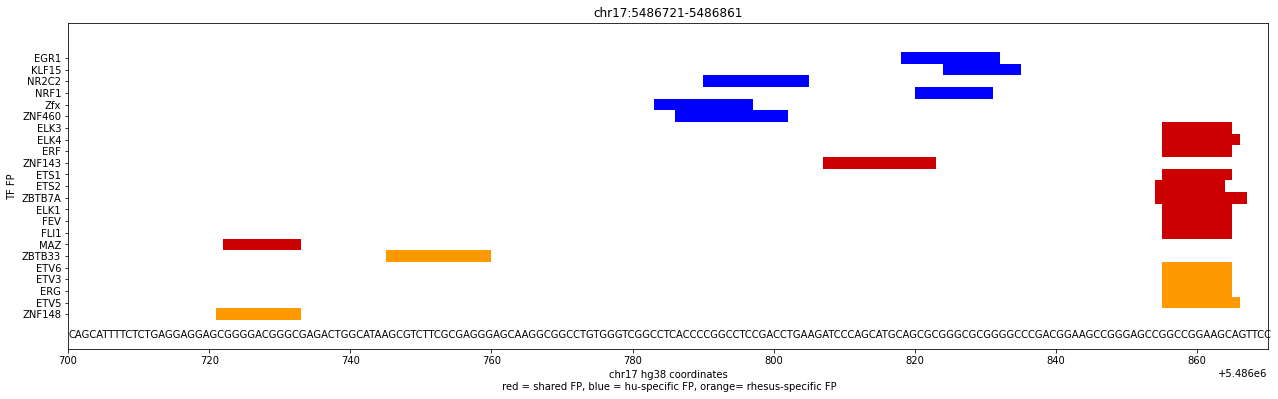

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(21.5,6))
test =test.sort_values(by="color", ascending= False)
plt.barh(test["tfid_label"], test["len"], left=test["start_tf_lifted"], 
         height=1,
        color=test["color"],
         #label = ["cons", "hu", "rhe"]
       )
chr_ = region_id.split(":")[0]
ax.set(
    title=region_id,
    xlim = (5486700,5486870),
    xlabel=f"{chr_} hg38 coordinates\n red = shared FP, blue = hu-specific FP, orange= rhesus-specific FP",
    ylabel = "TF FP",
    ylim=(-3,25)
)
plt.text(x=5486700, y=-2, s="CAGCATTTTCTCTGAGGAGGAGCGGGGACGGGCGAGACTGGCATAAGCGT\
CTTCGCGAGGGAGCAAGGCGGCCTGTGGGTCGGCCTCACCCCGGCCTCCG\
ACCTGAAGATCCCAGCATGCAGCGCGGGCGCGGGGCCCGACGGAAGCCGG\
GAGCCGGCCGGAAGCAGTTCC")
plt.show()

In [16]:
test

,#chr,start,end,region_id,#chr_tf,start_tf,end_tf,tfid,score,strand,overlap,len,tfid2,color,id,start_tf_lifted,#chr_tf_lifted,end_tf_lifted,tfid_label
275378,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282792.0,5282804.0,ZNF148_MA1653.1,7.22528,-,12.0,12.0,chr16:5282792:5282804_ZNF148_MA1653.1,#ff9900,rh,5486721.0,chr17,5486733.0,ZNF148
56021,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282926.0,5282937.0,ETV5_MA0765.2,9.07968,-,6.0,11.0,chr16:5282926:5282937_ETV5_MA0765.2,#ff9900,rh,5486855.0,chr17,5486869.0,ETV5
45492,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282926.0,5282936.0,ERG_MA0474.2,8.29935,+,6.0,10.0,chr16:5282926:5282936_ERG_MA0474.2,#ff9900,rh,5486855.0,chr17,5486868.0,ERG
53105,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282926.0,5282936.0,ETV3_MA0763.1,8.19907,+,6.0,10.0,chr16:5282926:5282936_ETV3_MA0763.1,#ff9900,rh,5486855.0,chr17,5486868.0,ETV3
57447,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282926.0,5282936.0,ETV6_MA0645.1,8.57717,+,6.0,10.0,chr16:5282926:5282936_ETV6_MA0645.1,#ff9900,rh,5486855.0,chr17,5486868.0,ETV6
261383,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282816.0,5282831.0,ZBTB33_MA0527.1,8.29297,-,15.0,15.0,chr16:5282816:5282831_ZBTB33_MA0527.1,#ff9900,rh,5486745.0,chr17,5486760.0,ZBTB33
134872,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282793.0,5282804.0,MAZ_MA1522.1,7.46580,-,11.0,11.0,chr16:5282793:5282804_MAZ_MA1522.1,#cc0000,conserved,5486722.0,chr17,5486733.0,MAZ
62032,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282926.0,5282936.0,FLI1_MA0475.2,8.21448,+,6.0,10.0,chr16:5282926:5282936_FLI1_MA0475.2,#cc0000,conserved,5486855.0,chr17,5486868.0,FLI1
60636,chr16,5282792,5282932,chr17:5486721-5486861,chr16,5282926.0,5282936.0,FEV_MA0156.2,8.78611,+,6.0,10.0,chr16:5282926:5282936_FEV_MA0156.2,#cc0000,conserved,5486855.0,chr17,5486868.0,FEV
40277,chr17,5486721,5486861,chr17:5486721-5486861,chr17,5486855.0,5486865.0,ELK1_MA0028.2,8.25347,+,6.0,10.0,chr17:5486855.0:5486865.0_ELK1_MA0028.2,#cc0000,conserved,5486855.0,NaN,NaN,ELK1


# download JASPAR motif .svgs 

In [34]:
def dl_jaspar(tfid, strand):
    JASPAR_PATH = os.path.join(PATH, "jaspar_svg")

    os.chdir(JASPAR_PATH)

    if strand == "+":
        out = os.path.join(JASPAR_PATH, f"{tfid}.svg")
        
        cmd =f"wget https://jaspar2022.genereg.net/static/logos/all/svg/{tfid}.svg"
    
    else:    
        out = os.path.join(JASPAR_PATH, f"{tfid}.rc.svg")
        cmd = f"wget https://jaspar2022.genereg.net/static/logos/all/svg/{tfid}.rc.svg"
    
    if os.path.exists(out) is False:
        subprocess.call(cmd, shell=True)
        print(cmd)

In [33]:
for i, row in test.iterrows():
    tfid = row["tfid"].split("_")[1]
    strand = row["strand"]
    
    dl_jaspar(tfid, strand)


wget https://jaspar2022.genereg.net/static/logos/all/svg/MA1653.1.rc.svg


# check differential expression 

In [40]:
def add_fpkm_lo2fc(df, fpkm, rna):
    rna = rna.fillna(0)
    df = pd.merge(fpkm[["hgnc_symbol","FPKM_mean", "FPKM_Rep1", "FPKM_Rep2","ensembl_gene_id"]],df,
             right_on = "tfid_label", left_on="hgnc_symbol" )

    df = pd.merge(rna[["SYMBOL","log2FoldChange","padj", "ENSEMBL"]],df,
             right_on = "ensembl_gene_id", left_on="ENSEMBL" ).drop_duplicates()
    
   
    
    df = df.sort_values(by = "FPKM_mean", ascending = False).drop_duplicates()
    df["log2FoldChange"] = df['log2FoldChange']*-1 # reverse the log2foldchange (originally log2(rhesus/human), flip direction to reflect log2(human/rhesus))
    return df 

fpkm = pd.read_csv(FPKM, sep = '\t')
rna = pd.read_csv(RNA, sep = '\t')

In [41]:
fp = add_fpkm_lo2fc(test, fpkm, rna)
fp.drop_duplicates()

,SYMBOL,log2FoldChange,padj,ENSEMBL,hgnc_symbol,FPKM_mean,FPKM_Rep1,FPKM_Rep2,ensembl_gene_id,#chr,...,strand,overlap,len,tfid2,color,id,start_tf_lifted,#chr_tf_lifted,end_tf_lifted,tfid_label
5,ZNF460,-0.090607,3.513144e-01,ENSG00000197714,ZNF460,35.138475,36.988103,33.288846,ENSG00000197714,chr17,...,+,16.0,16.0,chr17:5486786.0:5486802.0_ZNF460_MA1596.1,#0000ff,hu,5486786.0,NaN,NaN,ZNF460
21,ETS1,4.916174,3.868816e-250,ENSG00000134954,ETS1,34.863198,35.136035,34.590362,ENSG00000134954,chr17,...,+,6.0,10.0,chr17:5486855.0:5486865.0_ETS1_MA0098.3,#cc0000,conserved,5486855.0,NaN,NaN,ETS1
20,ETS1,4.916174,3.868816e-250,ENSG00000134954,ETS1,34.863198,35.136035,34.590362,ENSG00000134954,chr16,...,+,6.0,10.0,chr16:5282926:5282936_ETS1_MA0098.3,#cc0000,conserved,5486855.0,chr17,5486868.0,ETS1
6,MAZ,-0.437248,1.014880e-03,ENSG00000103495,MAZ,30.315622,29.717682,30.913561,ENSG00000103495,chr16,...,-,11.0,11.0,chr16:5282793:5282804_MAZ_MA1522.1,#cc0000,conserved,5486722.0,chr17,5486733.0,MAZ
7,MAZ,-0.437248,1.014880e-03,ENSG00000103495,MAZ,30.315622,29.717682,30.913561,ENSG00000103495,chr17,...,-,11.0,11.0,chr17:5486722.0:5486733.0_MAZ_MA1522.1,#cc0000,conserved,5486722.0,NaN,NaN,MAZ
2,ZBTB7A,2.576113,5.715479e-114,ENSG00000178951,ZBTB7A,29.556128,33.036714,26.075543,ENSG00000178951,chr17,...,+,7.0,13.0,chr17:5486854.0:5486867.0_ZBTB7A_MA0750.2,#cc0000,conserved,5486854.0,NaN,NaN,ZBTB7A
1,ZBTB7A,2.576113,5.715479e-114,ENSG00000178951,ZBTB7A,29.556128,33.036714,26.075543,ENSG00000178951,chr16,...,+,7.0,13.0,chr16:5282925:5282938_ZBTB7A_MA0750.2,#cc0000,conserved,5486854.0,chr17,5486870.0,ZBTB7A
18,ZNF143,0.281494,2.474477e-02,ENSG00000166478,ZNF143,11.184197,10.783192,11.585202,ENSG00000166478,chr16,...,+,16.0,16.0,chr16:5282878:5282894_ZNF143_MA0088.2,#cc0000,conserved,5486807.0,chr17,5486823.0,ZNF143
19,ZNF143,0.281494,2.474477e-02,ENSG00000166478,ZNF143,11.184197,10.783192,11.585202,ENSG00000166478,chr17,...,+,16.0,16.0,chr17:5486807.0:5486823.0_ZNF143_MA0088.2,#cc0000,conserved,5486807.0,NaN,NaN,ZNF143
23,FLI1,0.373204,1.215372e-02,ENSG00000151702,FLI1,8.520231,8.207451,8.833011,ENSG00000151702,chr17,...,+,6.0,10.0,chr17:5486855.0:5486865.0_FLI1_MA0475.2,#cc0000,conserved,5486855.0,NaN,NaN,FLI1


In [59]:
fp.describe()

,log2FoldChange,padj,FPKM_mean,FPKM_Rep1,FPKM_Rep2,start,end,start_tf,end_tf,score,overlap,len,start_tf_lifted,end_tf_lifted
count,24.000000,2.400000e+01,24.000000,24.000000,24.000000,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,24.000000,24.000000,24.000000,2.400000e+01,1.100000e+01
mean,-0.089641,4.532768e-02,12.834217,13.093432,12.575001,5.393254e+06,5.393394e+06,5.393362e+06,5.393374e+06,8.002591,8.958333,11.583333,5.486830e+06,5.486852e+06
std,2.148004,1.082297e-01,13.089745,13.653019,12.598040,1.037952e+05,1.037952e+05,1.037873e+05,1.037878e+05,0.951958,3.838922,2.205067,4.031432e+01,4.168409e+01
min,-3.083464,0.000000e+00,0.009061,0.011592,0.006530,5.282792e+06,5.282932e+06,5.282793e+06,5.282804e+06,5.714300,6.000000,10.000000,5.486722e+06,5.486733e+06
25%,-1.117836,4.287164e-114,2.049674,1.823714,2.323963,5.282792e+06,5.282932e+06,5.282926e+06,5.282936e+06,7.556790,6.000000,10.000000,5.486815e+06,5.486868e+06
50%,-0.177498,4.488583e-07,7.529912,7.487660,7.572164,5.486721e+06,5.486861e+06,5.486754e+06,5.486768e+06,8.206775,7.000000,10.500000,5.486854e+06,5.486868e+06
75%,0.304421,1.530148e-02,29.556128,29.717682,26.075543,5.486721e+06,5.486861e+06,5.486832e+06,5.486842e+06,8.546670,11.000000,13.000000,5.486855e+06,5.486868e+06
max,4.916174,3.513144e-01,35.138475,36.988103,34.590362,5.486721e+06,5.486861e+06,5.486855e+06,5.486867e+06,9.433970,16.000000,16.000000,5.486855e+06,5.486870e+06


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import plot_params as pp
pp.fonts()

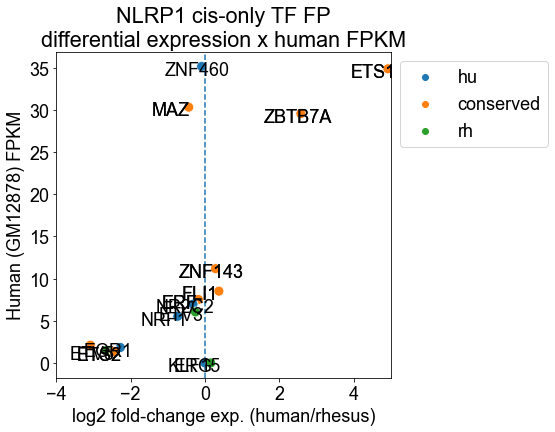

In [67]:

x = "log2FoldChange"
y = "FPKM_mean"
data= fp
hue = "id"
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(
    x=x,y=y,
    data=data,
    hue=hue,
    s=100
               )

# add annotations
for i, l in enumerate(data["tfid_label"]):
        #print(l, (data[x].iloc[i]+0.02, data[y].iloc[i]+0.02) )
        ax.annotate(l, (data[x].iloc[i]-1, data[y].iloc[i]-1) )
ax.axvline(0, ls = "--")
ax.set(title = f"NLRP1 cis-only TF FP\ndifferential expression x human FPKM",
      xlabel = "log2 fold-change exp. (human/rhesus)",
       ylabel = "Human (GM12878) FPKM",
       xlim =(-4,5)
      )
ax.legend(bbox_to_anchor = (1,1))
out = os.path.join(RE, f"NLRP1_cis-only_FP_DE_x_FPKM_RNAseq.pdf")
plt.savefig(out, bbox_inches = "tight")

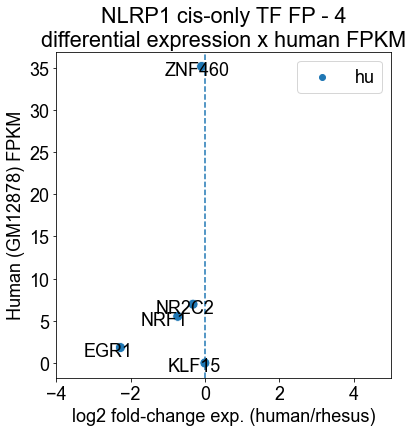

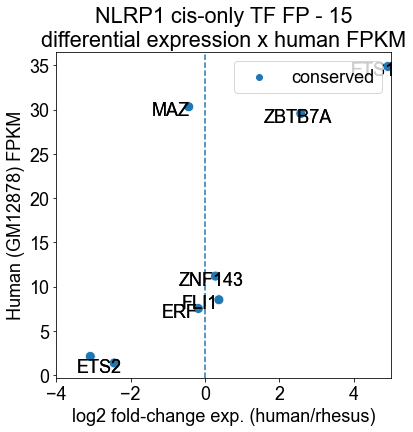

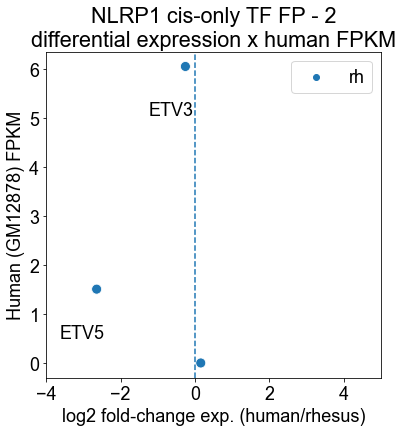

In [68]:
for i in fp.id.unique():
    x = "log2FoldChange"
    y = "FPKM_mean"
    data= fp.loc[fp["id"]==i]
    hue = "id"
    fig, ax = plt.subplots(figsize = (6,6))
    sns.scatterplot(
        x=x,y=y,
        data=data,
        hue=hue,
        s=100
                   )

    # add annotations
    for i, l in enumerate(data["tfid_label"]):
            #print(l, (data[x].iloc[i]+0.02, data[y].iloc[i]+0.02) )
            ax.annotate(l, (data[x].iloc[i]-1, data[y].iloc[i]-1) )
    ax.axvline(0, ls = "--")
    ax.set(title = f"NLRP1 cis-only TF FP - {i}\ndifferential expression x human FPKM",
          xlabel = "log2 fold-change exp. (human/rhesus)",
           ylabel = "Human (GM12878) FPKM",
           xlim =(-4,5)
          )
    ax.legend(bbox_to_anchor = (1,1))
    out = os.path.join(RE, f"NLRP1_cis-only_FP_DE_x_FPKM_RNAseq-{i}.pdf")
    plt.savefig(out, bbox_inches = "tight")

In [66]:
RE

'/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/TF_footprinting'